# Mnist classification from scratch

Here we import the relevant modules we will be using throughout the project

In [206]:
import pandas as pd
import numpy as np

The following block contains the code to create a test and training set.
1. First we use pandas to read the csv files called mnist_training and mnist_test that were downloaded from kaggle
2. We then convert these into a numpy array as this will allow us to work with the data more easily
3. We then shuffle both the the test and training data to remove any bias. We use np.random.shuffle which shuffles the rows meaning the labels we have still correspong to the appropriate rows
4. Lastly we transpose our matrix so that the labels are the first row in our data as opposed to the first column and store the shape of the array in the variables a,b and m,n (this will be important later).

In [461]:
training_data = pd.read_csv('mnist_train.csv')
testing_data = pd.read_csv('mnist_test.csv')

training_data = np.array(training_data)
testing_data = np.array(testing_data)

np.random.shuffle(training_data)
np.random.shuffle(testing_data)

a,b = training_data.shape
m,n = testing_data.shape

training_data = training_data.T
testing_data = testing_data.T




The following block contains the code for getting the labels out of the training and test sets

1. We assign the variable y_train to the first row of the training data as this is the row that stores all the labels due to the fact that we transposed the matrix earlier
2. We then assign everything else in the array to the variable x_train as this is all the data that corresponds with the label and will be what we feed into our model
3. We then normalise this data by dividing by 255 as the mnist dataset is grayscale and each value is between 0 and 255 
4. We repeat this with the test set

In [469]:
y_train= training_data[0]
x_train = training_data[1:b]
x_train = x_train/255

y_test = testing_data[0]
x_test = testing_data[1:n]
x_test = x_test/255

This is block is where we initialise our weights and biases for Layer 1(WL1 and BL1 respectively) and Layer 2(WL2 and BL2 respectively)

We initialise the weights using the HE initialisation technique as later on we will be using the ReLu activation function. Wl1 is initialised with parameters 15 and 784 as 15 is the amount of neurons in our hidden layer and 784 is the amount of neurons in the initial input layer. Wl2 is initialised with 10 and 15 as 10 is the amount of neurons in our output layer and once again the 15 is for the hidden layer. 

Note 15 was chosen arbitrarily.

In [326]:
def initialise():
    W1 = np.random.randn(15,784)*np.sqrt(2/784)
    B1 = np.random.randn(15,1)*np.sqrt(2/1)
    W2 = np.random.randn(10,15)*np.sqrt(2/10)
    B2 = np.random.randn(10,1)*np.sqrt(2/1)
    return W1,B1,W2,B2

In this block we compute the forward pass:
1. Firstly we need to compute the unactivated first layer. We do this by multiplying our input layer x by our weights for the first layer WL1 and add on the bias BL1
2. This however,  is just a linear combination and we need to introduce some non-linearity so that our network is able to learn non-linear patterns to do this we use the ReLu activation function
3. We now have an activated first layer but require the second layer to do this we multiply our activated first layer by the weights and biases for the second layer WL2 and BL2 respectively.
4. Next we apply the softmax activation on the second layer as this converts all the values in the neurons in the second layer into values between 0 and 1 representing probabilities. Allowing each of the 10 neurons to output a probability indicating how likely the image that has been fed into the network is a number from 0-9

In [553]:
def forward_pass(W1,B1,W2,B2,X):
    #unactivated first layer
    Z1 = np.dot(W1, X) + B1
    #Activated first layer
    A1 = np.maximum(Z1,0)
    #unactivated second layer
    Z2 = np.dot(W2, A1) + B2
    #output layer
    Y_hat = np.exp(Z2)/sum(np.exp(Z2))
    return Z1, A1, Z2, Y_hat

The following block represents code for one hot encoding which will be useful later on. 
One hot encoding allows us to represent the labels we stored earlier as arrays that we can use for computations in steps later on such as backpropagation

In [562]:
def ohe(y):
    ohe = np.zeros((y.size, y.max()+1))
    ohe[np.arange(y.size), y] = 1
    return ohe.T

Derivative of the relu activation function

In [561]:
def derivative_relu(Z1):
    return Z1 > 0

The following block contains the code needed for backpropagation 

To improve our model we require a loss function. A loss function is a function that measures the error between the actual results and our predicted results. We can use this function and aim to minimise it which in turn will make our model more accurate. The loss function I have chosen for this problem is the categorical crossentropy loss function as we have a multiclassfication problem at hand and I have used a softmax activation function for my last layer. Below is my derivation for all the changes.Note that the non activated layers are denoted by Z1, Z2 in the code and Xs in the working out.Furthermore, the input layer is denoted by I instead of X. Below we work out the change in the loss function with respect to the different weights and biases to do this we use partial derivatives and the chain rule
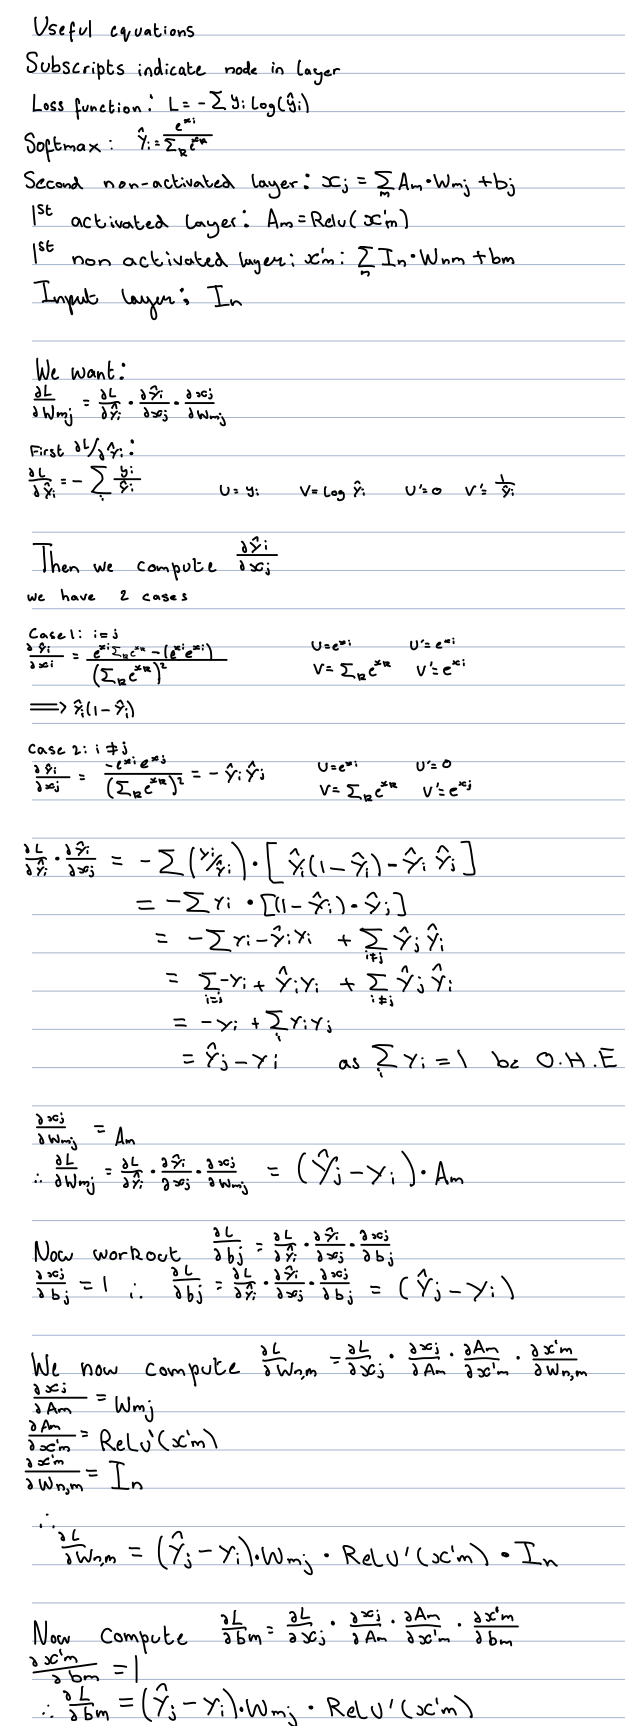In the code we divide by a and sum the biases because we want the average of the gradient for all the examples in our training data 

In [554]:
def backwards_propogation(Z1, A1,Z2 ,Y_hat ,W1, W2, X,Y ):
        DW2 = 1/a *(np.dot((Y_hat - ohe(Y)), A1.T))
        DB2 = 1/a *np.sum((Y_hat - ohe(Y)))
        DW1 = 1/a *(np.dot(((np.dot(W2.T, Y_hat - ohe(Y))) * derivative_relu(Z1)), X.T))
        DB1 = 1/a *(np.sum((np.dot(W2.T, Y_hat - ohe(Y))) * derivative_relu(Z1)))
        return DW1, DB1, DW2, DB2   

This function takes in the predicted values from our model and the actual labels. It then stores the position of the max number in the array in the variable model_preds then initialises an empty an array called matches. After this it iterates the length of the label set and checks to see if the value of model_predis matches the label for the same index if it does it adds it to the matches list. The length of the list is then divided by the total length and this gives us the percentage of correct predictions 

In [474]:
def predict(Y_hat, Y):
    model_preds = np.argmax(Y_hat,0)
    matches = []
    length = len(Y)
    for i in range(length):
        if model_preds[i] == Y[i]:
            matches.append(i)
    percentage = (len(matches)/length)*100
    print(f"{percentage}%")

This block of code is actually how the model learns. 
It employs gradient descent which initialises the weights and biases and then does forward and backwards propagations for the set iterations. Each time it calculates the effect of the weights and biases on the loss function using the backwards_propagation method and then updates the weights and biases according effectively getting better and better each time. The lr stands for learning rate and is a hyperparameter that effectively controls the speed at which the model learns

In [571]:
def GD(X, Y, lr, iteration):
    W1,B1,W2,B2 = initialise()
    for i in range(iteration):
        Z1, A1, Z2, Y_hat = forward_pass(W1,B1,W2,B2, X)
        DW1, DB1, DW2, DB2 = backwards_propogation(Z1, A1, Z2, Y_hat, W1, W2, X, Y)
        W1 = W1 - lr*(DW1)
        B1 = B1 - lr*(DB1)
        W2 = W2 - lr*(DW2)
        B2 = B2 - lr*(DB2)
    predict(Y_hat,Y)
    return W1, B1, W2, B2

This block of code runs the gradient descent on the training data and stores the weights so they can be used on the test set or unseen data

In [567]:
W1, B1, W2, B2 = GD(x_train, y_train, 0.2, 500)

91.84333333333333%


This code performs a forward pass on unsee data and stores the results so that we can call our predict function on the Y_hat data along with the correct labels. This works as we fine tuned our weights and biases by using gradient descent above.

In [570]:
Z1,A1,Z2,Y_hat=forward_pass(W1,B1,W2,B2,x_test)
predict(Y_hat,y_test)

92.08%
